In [ ]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from codecarbon import EmissionsTracker
from eco2ai import Tracker

sys.path.append(os.path.abspath(".."))

import imputation as imp
import forecasting as fc

In [3]:
df = pd.read_csv("datasets/genome/electricity_cleaned.csv", index_col='timestamp', parse_dates=True)
df = df.select_dtypes(include="number")

In [4]:
site_ids = [
    "Panther",
    "Robin",
    "Fox",
    # "Rat",
    "Bear",
    "Lamb",
    "Peacock",
    "Moose",
    "Gator",
    "Bull",
    "Bobcat",
    "Crow",
    # "Shrew",
    "Swan",
    "Wolf",
    # "Hog",
    # "Eagle",
    "Cockatoo",
    # "Mouse",
]

In [ ]:
imputation_methods = {
    "LOCF": imp.locf,
    "NOCB": imp.nocb,
    "Linear Interpolation": imp.linear_interpolation,
    "Linear Regression": imp.linear_regression,
    "K-Nearest Neighbor": imp.knn,
    "MICE": imp.mice,
    "LightGBM": imp.lightgbm,
}

imputed = {}

for site in site_ids:
    cols = [col for col in df.columns if col.startswith(site)]
    df_site = df[cols]
    rng = np.random.default_rng(seed=42)
    target = rng.choice(cols)
    df_masked, samples = imp.create_mcar_data(df_site, missing=0.2, seed=42)

    for n, f in imputation_methods.items():
        cc_tracker = EmissionsTracker(
            project_name=n,
            output_dir="performance/results",
            output_file="genome_codecarbon.csv",
        )
        eco_tracker = Tracker(project_name=n, file_name="performance/results/genome_eco2ai.csv")

        # Start time and emission trackers
        cc_tracker.start()
        eco_tracker.start()

        df_imputed = f(df_masked.copy())

        # Stop trackers
        emissions = cc_tracker.stop()
        eco_tracker.stop()

        # Store imputed data in dictionary
        imputed[(site, n)] = {
            "data": df_imputed,
            "target": target,
            "original": df_site,
            "samples": samples,
        }

        # Get error metrics only for the masked values
        i = df_site.columns.get_loc(target)
        mask = samples[:, i]
        y_true = df_site.values[:, i][mask]
        y_pred = df_imputed.values[:, i][mask]

        valid = (~np.isnan(y_true)) & (~np.isnan(y_pred))
        y_true = y_true[valid]
        y_pred = y_pred[valid]

        # Compute error
        mae = mean_absolute_error(y_true, y_pred)
        nrmse = root_mean_squared_error(y_true, y_pred) / (np.max(y_true) - np.min(y_true))

        r = pd.DataFrame(
            [
                {
                    "method": n,
                    "site": site,
                    "target": target,
                    "dataset": "genome",
                    "MAE": mae,
                    "NRMSE": nrmse,
                }
            ]
        )
        r.to_csv("performance/results/genome_performance.csv", mode="a", index=False, header=False)

In [11]:
forecasting = {}

for i, ((site, name), d) in enumerate(imputed.items()):
    df_imputed = d["data"]
    features = [col for col in df_imputed.columns if col != target]

    X = df_imputed[features]
    y = df_imputed[d["target"]]

    X_train, X_test, y_train, y_test = fc.split_data(X, y, train_size=0.8)

    model = LGBMRegressor(force_col_wise=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    valid = (~np.isnan(y_test)) & (~np.isnan(y_pred))
    mae = mean_absolute_error(y_test[valid], y_pred[valid])

    forecasting[(site, name)] = {
        "site": site,
        "method": name,
        "target": target,
        "MAE": mae,
        "dataset": "genome",
    }


df_forecasting = pd.DataFrame.from_dict(forecasting, orient="index").reset_index()
df_forecasting.rename(columns={"level_0": "site", "level_1": "method"}, inplace=True)
df_forecasting.to_csv("performance/results/genome_forecasting.csv", index=False)

[LightGBM] [Info] Total Bins 26102
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 105
[LightGBM] [Info] Start training from score 0.567292
[LightGBM] [Info] Total Bins 26076
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 105
[LightGBM] [Info] Start training from score 0.785425
[LightGBM] [Info] Total Bins 26722
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 105
[LightGBM] [Info] Start training from score 0.785028
[LightGBM] [Info] Total Bins 26775
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 105
[LightGBM] [Info] Start training from score 0.827961
[LightGBM] [Info] Total Bins 26744
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 105
[LightGBM] [Info] Start training from score 0.825996
[LightGBM] [Info] Total Bins 26775
[LightGBM] [Info] Number of data points in the train se

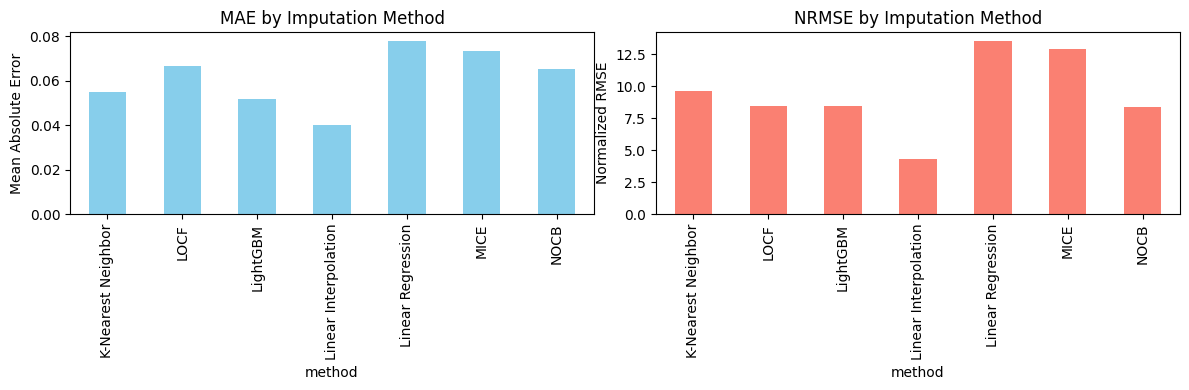

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

df_performance = pd.read_csv("performance/results/genome_performance.csv")
df_performance["MAE"] = pd.to_numeric(df_performance["MAE"], errors="coerce")
df_performance["NRMSE"] = pd.to_numeric(df_performance["NRMSE"], errors="coerce")
df_plot = df_performance.groupby("method")[["MAE", "NRMSE"]].mean()

df_plot["MAE"].plot(kind="bar", ax=axs[0], color="skyblue")
axs[0].set_title("MAE by Imputation Method")
axs[0].set_ylabel("Mean Absolute Error")
axs[0].set_xticklabels(df_plot.index, rotation=90)

df_plot["NRMSE"].plot(kind="bar", ax=axs[1], color="salmon")
axs[1].set_title("NRMSE by Imputation Method")
axs[1].set_ylabel("Normalized RMSE")
axs[1].set_xticklabels(df_plot.index, rotation=90)

plt.tight_layout()
plt.savefig(f"performance/figures/genome/imputation.png")
plt.show()

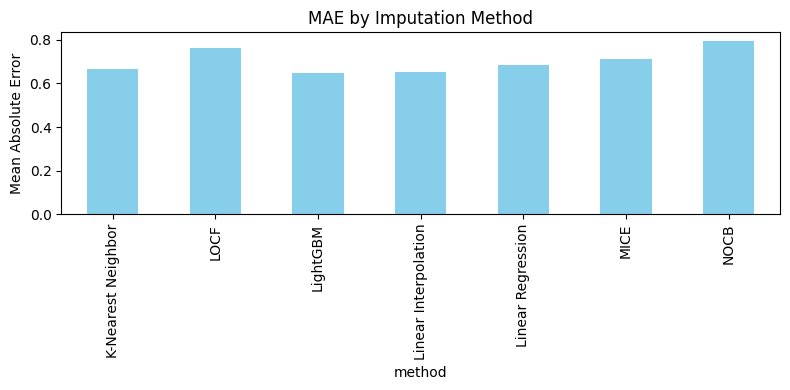

In [63]:
df_performance = pd.read_csv("performance/results/genome_forecasting.csv")
df_performance["MAE"] = pd.to_numeric(df_performance["MAE"], errors="coerce")
df_plot = df_performance.groupby("method")[["MAE"]].mean()

fig, ax = plt.subplots(figsize=(8, 4))

df_plot["MAE"].plot(kind="bar", ax=ax, color="skyblue")
plt.title("MAE by Imputation Method")
plt.ylabel("Mean Absolute Error")
plt.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.savefig(f"performance/figures/genome/forecasting.png")

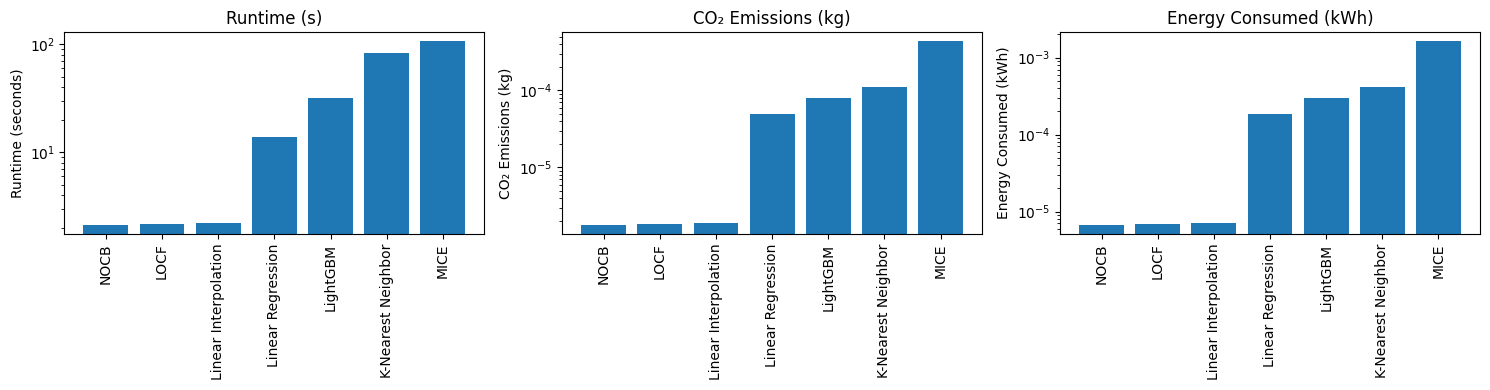

In [88]:
df_emission = pd.read_csv(f"performance/results/genome_codecarbon.csv")
df_plot = (
    df_emission.groupby("project_name")[["duration", "emissions", "energy_consumed"]]
    .mean()
    .sort_values("duration")
)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].bar(df_plot.index, df_plot["duration"])
axs[0].set_title("Runtime (s)")
axs[0].set_yscale("log")
axs[0].set_ylabel("Runtime (seconds)")
axs[0].tick_params(axis="x", rotation=90)

axs[1].bar(df_plot.index, df_plot["emissions"])
axs[1].set_title("CO₂ Emissions (kg)")
axs[1].set_yscale("log")
axs[1].set_ylabel("CO₂ Emissions (kg)")
axs[1].tick_params(axis="x", rotation=90)

axs[2].bar(df_plot.index, df_plot["energy_consumed"])
axs[2].set_title("Energy Consumed (kWh)")
axs[2].set_yscale("log")
axs[2].set_ylabel("Energy Consumed (kWh)")
axs[2].tick_params(axis="x", rotation=90)


plt.tight_layout()
plt.savefig("performance/figures/genome/emissions_codecarbon.png")
plt.show()

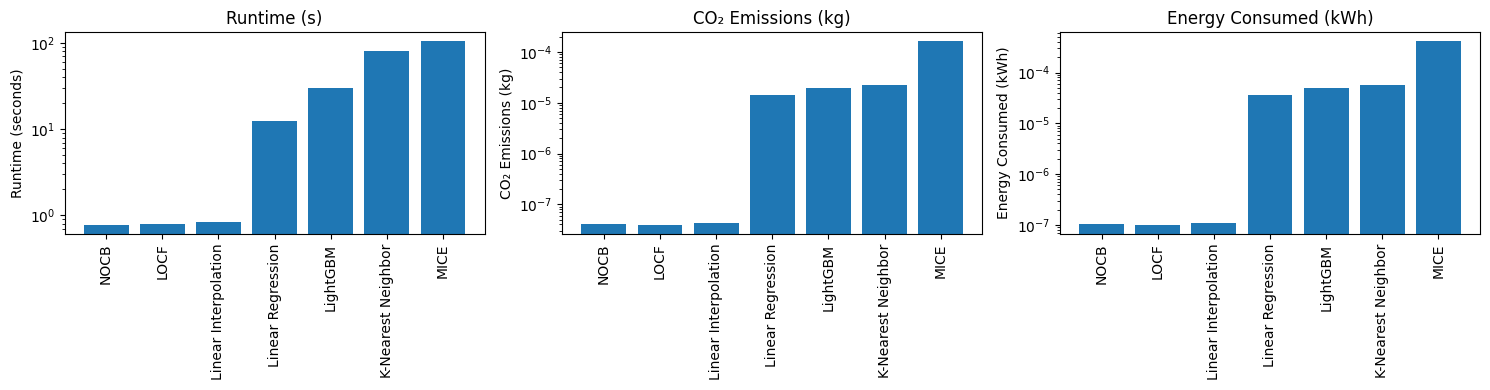

In [89]:
# Plot eco2ai performance
df_emission = pd.read_csv("performance/results/genome_eco2ai.csv")
df_plot = (
    df_emission.groupby("project_name")[["duration(s)", "CO2_emissions(kg)", "power_consumption(kWh)"]]
    .mean()
    .sort_values("duration(s)")
)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].bar(df_plot.index, df_plot["duration(s)"])
axs[0].set_title("Runtime (s)")
axs[0].set_yscale("log")
axs[0].set_ylabel("Runtime (seconds)")
axs[0].tick_params(axis="x", rotation=90)

axs[1].bar(df_plot.index, df_plot["CO2_emissions(kg)"])
axs[1].set_title("CO₂ Emissions (kg)")
axs[1].set_yscale("log")
axs[1].set_ylabel("CO₂ Emissions (kg)")
axs[1].tick_params(axis="x", rotation=90)

axs[2].bar(df_plot.index, df_plot["power_consumption(kWh)"])
axs[2].set_title("Energy Consumed (kWh)")
axs[2].set_yscale("log")
axs[2].set_ylabel("Energy Consumed (kWh)")
axs[2].tick_params(axis="x", rotation=90)


plt.tight_layout()
plt.savefig(f"performance/figures/genome/emissions_eco2ai.png")
plt.show()